# HSMA Exercise

The data loaded in this exercise is for seven acute stroke units, and whether a patient receives clost-busting treatment for stroke.

How accurately can you predict treatment?

In [1]:
import pandas as pd

# Download data 
# (not required if running locally and have previously downloaded data)

download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '2004_titanic/master/jupyter_notebooks/data/hsma_stroke.csv'        
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data to data subfolder
    data.to_csv(data_directory + 'hsma_stroke.csv', index=False)
    
# Load data    
data = pd.read_csv('data/hsma_stroke.csv')
# Make all data 'float' type
data = data.astype(float)
# Show data
data.head()

,Clotbuster given,Hosp_1,Hosp_2,Hosp_3,Hosp_4,Hosp_5,Hosp_6,Hosp_7,Male,Age,...,S2NihssArrivalFacialPalsy,S2NihssArrivalMotorArmLeft,S2NihssArrivalMotorArmRight,S2NihssArrivalMotorLegLeft,S2NihssArrivalMotorLegRight,S2NihssArrivalLimbAtaxia,S2NihssArrivalSensory,S2NihssArrivalBestLanguage,S2NihssArrivalDysarthria,S2NihssArrivalExtinctionInattention
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,...,3.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,91.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,...,2.0,0.0,4.0,1.0,4.0,0.0,1.0,2.0,2.0,1.0


In [2]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# sklearn for pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# TensorFlow sequential model
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

In [4]:
# steal the data
#change the data so it fits with the clotbuster dataframe



#data.drop('Clotbuster given', inplace=True, axis=1)
X = data.drop('Clotbuster given',axis=1) # X = all 'data' except the 'survived' column
y = data['Clotbuster given'] # y = 'survived' column from 'data'
# Convert to NumPy as required for k-fold splits
X_np = X.values
y_np = y.values

In [5]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc

In [72]:
def make_net(number_features, 
             hidden_layers=3, 
             hidden_layer_neurones=128, 
             dropout=0.0, 
             learning_rate=0.003):
    
    """Make TensorFlow neural net"""
    
    # Clear Tensorflow 
    K.clear_session()
    
    # Set up neural net
    net = Sequential()
    
    # Add hidden hidden_layers using a loop
    for i in range(hidden_layers):
        # Add fully connected layer with ReLu activation
        net.add(Dense(
            hidden_layer_neurones, 
            input_dim=number_features,
            activation='relu'))
        # Add droput layer
        net.add(Dropout(dropout))
    
    # Add final sigmoid activation output
    net.add(Dense(1, activation='sigmoid'))    
    
    # Compiling model
    opt = Adam(lr=learning_rate)
    
    net.compile(loss='binary_crossentropy', 
                optimizer=opt, 
                metrics=['accuracy'])
    
    return net

In [73]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_np, y_np, test_size = 0.25, random_state=42)

# Scale X data
X_train_sc, X_test_sc = scale_data(X_train, X_test)

In [74]:
def calculate_accuracy(model, X_train_sc, X_test_sc, y_train, y_test):
    """Calculate and print accuracy of training and test data fits"""    
    
    ### Get accuracy of fit to training data
    probability = model.predict(X_train_sc)
    y_pred_train = probability >= 0.5
    y_pred_train = y_pred_train.flatten()
    accuracy_train = np.mean(y_pred_train == y_train)
    
    ### Get accuracy of fit to test data
    probability = model.predict(X_test_sc)
    y_pred_test = probability >= 0.5
    y_pred_test = y_pred_test.flatten()
    accuracy_test = np.mean(y_pred_test == y_test)

    # Show acuracy
    print (f'Training accuracy {accuracy_train:0.3f}')
    print (f'Test accuracy {accuracy_test:0.3f}')

In [75]:
def plot_training(history_dict):
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']
    epochs = range(1, len(acc_values) + 1)

    plt.plot(epochs, acc_values, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [109]:
# Define save checkpoint callback (only save if new best validation results)
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'model_checkpoint.h5', save_best_only=True)

# Define early stopping callback
# Stop when no validation improvement for 25 epochs
# Restore weights to best validation accuracy
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=30, restore_best_weights=True)

# Define network
number_features = X_train_sc.shape[1]
model = make_net(
    number_features,
    hidden_layers=1,
    hidden_layer_neurones=175,
    dropout=0.5)

### Train model (and stote training info in history)
history = model.fit(X_train_sc,
                    y_train,
                    epochs=200,
                    batch_size=32,
                    validation_data=(X_test_sc, y_test),
                    verbose=0,
                    callbacks=[checkpoint_cb, early_stopping_cb])

In [110]:
# Show acuracy
calculate_accuracy(model, X_train_sc, X_test_sc, y_train, y_test)

15/15 [==============================] - 0s 2ms/step
Training accuracy 0.865
Test accuracy 0.841


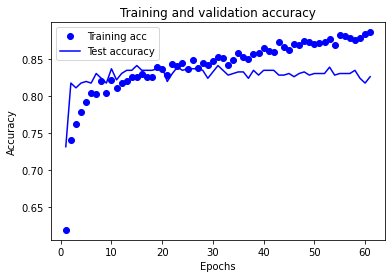

In [111]:
plot_training(history.history)